## CIFAR 10

In [34]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

You can get the data via:

    wget http://pjreddie.com/media/files/cifar.tgz    
**Important:** Before proceeding, the student must reorganize the downloaded dataset files to match the expected directory structure, so that there is a dedicated folder for each class under 'test' and 'train', e.g.:

```
* test/airplane/airplane-1001.png
* test/bird/bird-1043.png

* train/bird/bird-10018.png
* train/automobile/automobile-10000.png
```

The filename of the image doesn't have to include its class.

数据需要手动添加进目录。

In [35]:
from fastai.conv_learner import *
PATH = "data/cifar/"
os.makedirs(PATH,exist_ok=True)

!ls {PATH}

if not os.path.exists(f"{PATH}/train/bird"):
   raise Exception("expecting class subdirs under 'train/' and 'test/'")
!ls {PATH}/train

labels.txt  models  test  tmp  train
bird  car  cat	deer  dog  frog  horse	plane  ship  truck


In [36]:
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
# stats是统计数据：每个通道的mean 和 每个通道的 std
stats = (np.array([ 0.4914 ,  0.48216,  0.44653]), np.array([ 0.24703,  0.24349,  0.26159]))

In [37]:
# 定义获取指定sz,bs的数据集
def get_data(sz,bs):
    tfms = tfms_from_stats(stats, sz, aug_tfms=[RandomFlip()], pad=sz//8)
    return ImageClassifierData.from_paths(PATH, val_name='test', tfms=tfms, bs=bs)

In [38]:
# 批大小
bs=256

### Look at data

In [39]:
# 获取数据集
data = get_data(32,4)

In [40]:
# 训练集Dataloader取一个样本
x,y=next(iter(data.trn_dl))

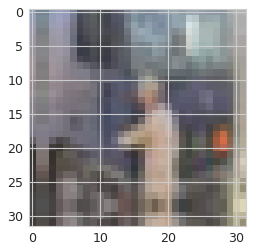

In [41]:
plt.imshow(data.trn_ds.denorm(x)[0]);

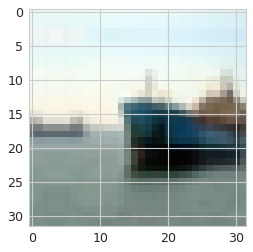

In [42]:
plt.imshow(data.trn_ds.denorm(x)[1]);

## Fully connected model

先看全连接层的效果

In [43]:
data = get_data(32,bs)

In [44]:
lr=1e-2

From [this notebook](https://github.com/KeremTurgutlu/deeplearning/blob/master/Exploring%20Optimizers.ipynb) by our student Kerem Turgutlu:

这个链接打不开了。

In [45]:
# 全连接模型
class SimpleNet(nn.Module):
    def __init__(self, layers):
        super().__init__()
        # 根据定义的层数设定全连接层的数目
        self.layers = nn.ModuleList([
            nn.Linear(layers[i], layers[i + 1]) for i in range(len(layers) - 1)])
        
    def forward(self, x):
        x = x.view(x.size(0), -1)
        for l in self.layers:
            l_x = l(x)
            x = F.relu(l_x)
        return F.log_softmax(l_x, dim=-1)

In [46]:
# 构建一个学习器
learn = ConvLearner.from_model_data(SimpleNet([32*32*3, 40,10]), data)

In [47]:
learn, [o.numel() for o in learn.model.parameters()]

(SimpleNet(
   (layers): ModuleList(
     (0): Linear(in_features=3072, out_features=40, bias=True)
     (1): Linear(in_features=40, out_features=10, bias=True)
   )
 ), [122880, 40, 400, 10])

In [48]:
learn.summary()

OrderedDict([('Linear-1',
              OrderedDict([('input_shape', [-1, 3072]),
                           ('output_shape', [-1, 40]),
                           ('trainable', True),
                           ('nb_params', 122920)])),
             ('Linear-2',
              OrderedDict([('input_shape', [-1, 40]),
                           ('output_shape', [-1, 10]),
                           ('trainable', True),
                           ('nb_params', 410)]))])

In [49]:
learn.lr_find()

 76%|███████▌  | 149/196 [00:34<00:11,  4.10it/s, loss=6.27]

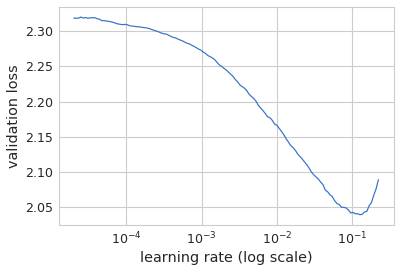

In [51]:
# 看图找最优
learn.sched.plot()

In [52]:
%time learn.fit(lr, 2)

epoch      trn_loss   val_loss   accuracy                   
    0      1.759376   1.651127   0.4136    
    1      1.649178   1.555604   0.4475                     
CPU times: user 11min 16s, sys: 1min 43s, total: 13min
Wall time: 1min 4s


[array([1.5556]), 0.4475]

In [53]:
%time learn.fit(lr, 2, cycle_len=1)

epoch      trn_loss   val_loss   accuracy                   
    0      1.600987   1.502794   0.4752    
    1      1.579483   1.484993   0.4799                     
CPU times: user 10min, sys: 1min 39s, total: 11min 39s
Wall time: 1min 9s


[array([1.48499]), 0.4799]

## CNN

全连接层这种线性结构显然不行，现在使用CNN进行测试。

ResNet的基础版本。

In [57]:
class ConvNet(nn.Module):
    def __init__(self, layers, c):
        super().__init__()
        self.layers = nn.ModuleList([
            nn.Conv2d(layers[i], layers[i + 1], kernel_size=3, stride=2) # 这里用到了stride Convolution,步长不为1
            for i in range(len(layers) - 1)])
        self.pool = nn.AdaptiveMaxPool2d(1) # 最新的AdaptivePool,参数指的是输出的大小
        self.out = nn.Linear(layers[-1], c) # 全连接层
        
    def forward(self, x):
        for l in self.layers: x = F.relu(l(x))
        x = self.pool(x)
        x = x.view(x.size(0), -1) 
        return F.log_softmax(self.out(x), dim=-1)

In [58]:
learn = ConvLearner.from_model_data(ConvNet([3, 20, 40, 80], 10), data)

In [59]:
learn.summary()

OrderedDict([('Conv2d-1',
              OrderedDict([('input_shape', [-1, 3, 32, 32]),
                           ('output_shape', [-1, 20, 15, 15]),
                           ('trainable', True),
                           ('nb_params', 560)])),
             ('Conv2d-2',
              OrderedDict([('input_shape', [-1, 20, 15, 15]),
                           ('output_shape', [-1, 40, 7, 7]),
                           ('trainable', True),
                           ('nb_params', 7240)])),
             ('Conv2d-3',
              OrderedDict([('input_shape', [-1, 40, 7, 7]),
                           ('output_shape', [-1, 80, 3, 3]),
                           ('trainable', True),
                           ('nb_params', 28880)])),
             ('AdaptiveMaxPool2d-4',
              OrderedDict([('input_shape', [-1, 80, 3, 3]),
                           ('output_shape', [-1, 80, 1, 1]),
                           ('nb_params', 0)])),
             ('Linear-5',
              OrderedDict

In [69]:
learn.lr_find(start_lr=1e-3, end_lr=100)

 68%|██████▊   | 133/196 [00:23<00:09,  6.75it/s, loss=2.56]

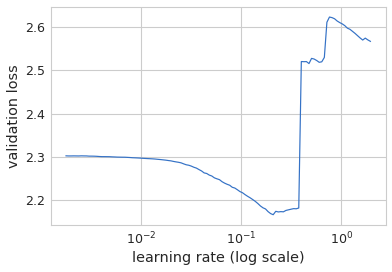

In [70]:
learn.sched.plot()

In [71]:
%time learn.fit(1e-1, 2)

epoch      trn_loss   val_loss   accuracy                   
    0      1.698812   1.723138   0.3806    
    1      1.504461   1.448768   0.4694                     
CPU times: user 9min 41s, sys: 1min 38s, total: 11min 20s
Wall time: 1min 7s


[array([1.44877]), 0.4694]

In [72]:
%time learn.fit(1e-1, 4, cycle_len=1)

epoch      trn_loss   val_loss   accuracy                   
    0      1.329124   1.264409   0.5389    
    1      1.25644    1.196442   0.5739                     
    2      1.222785   1.157025   0.5872                     
    3      1.177997   1.126127   0.5981                     
CPU times: user 19min 38s, sys: 3min 24s, total: 23min 2s
Wall time: 2min 27s


[array([1.12613]), 0.5981]

## Refactored

重构

In [75]:
# 卷积层
class ConvLayer(nn.Module):
    def __init__(self, ni, nf):
        super().__init__()
        self.conv = nn.Conv2d(ni, nf, kernel_size=3, stride=2, padding=1) #增加Padding，防止边缘信息丢失
        
    def forward(self, x): return F.relu(self.conv(x))

In [79]:
# 结构跟之前
class ConvNet2(nn.Module):
    def __init__(self, layers, c):
        super().__init__()
        self.layers = nn.ModuleList([ConvLayer(layers[i], layers[i + 1])
            for i in range(len(layers) - 1)])
        self.out = nn.Linear(layers[-1], c)
        
    def forward(self, x):
        for l in self.layers: x = l(x)
        x = F.adaptive_max_pool2d(x, 1) # 将adaptivenmaxPool通过F来调用，可以观察到summary中不存在这个层，因为maxpool本身不具备参数
        x = x.view(x.size(0), -1)
        return F.log_softmax(self.out(x), dim=-1)

In [77]:
learn = ConvLearner.from_model_data(ConvNet2([3, 20, 40, 80], 10), data)

In [78]:
learn.summary()

OrderedDict([('Conv2d-1',
              OrderedDict([('input_shape', [-1, 3, 32, 32]),
                           ('output_shape', [-1, 20, 16, 16]),
                           ('trainable', True),
                           ('nb_params', 560)])),
             ('ConvLayer-2',
              OrderedDict([('input_shape', [-1, 3, 32, 32]),
                           ('output_shape', [-1, 20, 16, 16]),
                           ('nb_params', 0)])),
             ('Conv2d-3',
              OrderedDict([('input_shape', [-1, 20, 16, 16]),
                           ('output_shape', [-1, 40, 8, 8]),
                           ('trainable', True),
                           ('nb_params', 7240)])),
             ('ConvLayer-4',
              OrderedDict([('input_shape', [-1, 20, 16, 16]),
                           ('output_shape', [-1, 40, 8, 8]),
                           ('nb_params', 0)])),
             ('Conv2d-5',
              OrderedDict([('input_shape', [-1, 40, 8, 8]),
                 

In [80]:
%time learn.fit(1e-1, 2)

epoch      trn_loss   val_loss   accuracy                   
    0      1.717197   1.580857   0.4227    
    1      1.512216   1.486709   0.4596                     
CPU times: user 9min 27s, sys: 1min 47s, total: 11min 15s
Wall time: 1min 22s


[array([1.48671]), 0.4596]

In [81]:
%time learn.fit(1e-1, 2, cycle_len=1)

epoch      trn_loss   val_loss   accuracy                   
    0      1.397916   1.324519   0.5244    
    1      1.296161   1.236557   0.5605                     
CPU times: user 10min 39s, sys: 1min 44s, total: 12min 24s
Wall time: 1min 9s


[array([1.23656]), 0.5605]

## BatchNorm

批归一化，便于训练更深网络，防止梯度爆炸。

In [86]:
# 归一化层
class BnLayer(nn.Module):
    def __init__(self, ni, nf, stride=2, kernel_size=3):
        super().__init__()
        self.conv = nn.Conv2d(ni, nf, kernel_size=kernel_size, stride=stride,
                              bias=False, padding=1)
        self.a = nn.Parameter(torch.zeros(nf,1,1)) # nn.Parameter 就是指定PyTorch记录，并参与back propagation
        self.m = nn.Parameter(torch.ones(nf,1,1))
        
    def forward(self, x):
        x = F.relu(self.conv(x))
        x_chan = x.transpose(0,1).contiguous().view(x.size(1), -1)
        # 只在训练时进行归一化处理
        # 因为在验证时，没有必要再更改批归一化层的参数了。
        if self.training:
            self.means = x_chan.mean(1)[:,None,None] # 均值
            self.stds  = x_chan.std (1)[:,None,None] # 标准方差
        return (x-self.means) / self.stds *self.m + self.a # 缩放到了self.m，有帮助。

In [87]:
class ConvBnNet(nn.Module):
    def __init__(self, layers, c):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 10, kernel_size=5, stride=1, padding=2)
        self.layers = nn.ModuleList([BnLayer(layers[i], layers[i + 1])
            for i in range(len(layers) - 1)])
        self.out = nn.Linear(layers[-1], c)
        
    def forward(self, x):
        x = self.conv1(x) # 先增加一层范围较大的通道数较少的卷积层。
        for l in self.layers: x = l(x)
        x = F.adaptive_max_pool2d(x, 1)
        x = x.view(x.size(0), -1)
        return F.log_softmax(self.out(x), dim=-1)

In [88]:
learn = ConvLearner.from_model_data(ConvBnNet([10, 20, 40, 80, 160], 10), data)

In [89]:
learn.summary()

OrderedDict([('Conv2d-1',
              OrderedDict([('input_shape', [-1, 3, 32, 32]),
                           ('output_shape', [-1, 10, 32, 32]),
                           ('trainable', True),
                           ('nb_params', 760)])),
             ('Conv2d-2',
              OrderedDict([('input_shape', [-1, 10, 32, 32]),
                           ('output_shape', [-1, 20, 16, 16]),
                           ('trainable', True),
                           ('nb_params', 1800)])),
             ('BnLayer-3',
              OrderedDict([('input_shape', [-1, 10, 32, 32]),
                           ('output_shape', [-1, 20, 16, 16]),
                           ('nb_params', 0)])),
             ('Conv2d-4',
              OrderedDict([('input_shape', [-1, 20, 16, 16]),
                           ('output_shape', [-1, 40, 8, 8]),
                           ('trainable', True),
                           ('nb_params', 7200)])),
             ('BnLayer-5',
              OrderedDict([

In [90]:
%time learn.fit(3e-2, 2)

epoch      trn_loss   val_loss   accuracy                   
    0      1.518657   1.354423   0.5102    
    1      1.28588    1.207188   0.5696                     
CPU times: user 13min 23s, sys: 1min 59s, total: 15min 22s
Wall time: 1min 7s


[array([1.20719]), 0.5696]

In [91]:
%time learn.fit(1e-1, 4, cycle_len=1)

epoch      trn_loss   val_loss   accuracy                   
    0      1.223916   1.09158    0.6094    
    1      1.080679   0.967558   0.6589                     
    2      0.997373   0.912109   0.6732                      
    3      0.927883   0.86153    0.6988                      
CPU times: user 27min 39s, sys: 3min 58s, total: 31min 37s
Wall time: 2min 13s


[array([0.86153]), 0.6988]

## Deep BatchNorm

尝试增加卷积层深度

In [94]:
class ConvBnNet2(nn.Module):
    def __init__(self, layers, c):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 10, kernel_size=5, stride=1, padding=2)
        self.layers = nn.ModuleList([BnLayer(layers[i], layers[i+1])
            for i in range(len(layers) - 1)])
        self.layers2 = nn.ModuleList([BnLayer(layers[i+1], layers[i + 1], 1) # 指定stride=1，将不会改变卷积层Size，以此加深
            for i in range(len(layers) - 1)])
        self.out = nn.Linear(layers[-1], c)
        
    def forward(self, x):
        x = self.conv1(x)
        for l,l2 in zip(self.layers, self.layers2):
            x = l(x)
            x = l2(x)
        x = F.adaptive_max_pool2d(x, 1)
        x = x.view(x.size(0), -1)
        return F.log_softmax(self.out(x), dim=-1)

In [95]:
learn = ConvLearner.from_model_data(ConvBnNet2([10, 20, 40, 80, 160], 10), data)

In [96]:
%time learn.fit(1e-2, 2)

epoch      trn_loss   val_loss   accuracy                   
    0      1.468448   1.359141   0.5023    
    1      1.233166   1.130008   0.5942                     
CPU times: user 16min 52s, sys: 2min 10s, total: 19min 3s
Wall time: 58.9 s


[array([1.13001]), 0.5942]

In [97]:
%time learn.fit(1e-2, 2, cycle_len=1)

epoch      trn_loss   val_loss   accuracy                   
    0      1.036645   0.994114   0.6427    
    1      0.994912   0.939462   0.662                       
CPU times: user 17min 28s, sys: 2min 13s, total: 19min 42s
Wall time: 1min


[array([0.93946]), 0.662]

## Resnet

In [98]:
# Residual 残差网络层：y = x + f(x)
class ResnetLayer(BnLayer):
    def forward(self, x): return x + super().forward(x) # 残差网络的实现

In [99]:
class Resnet(nn.Module):
    def __init__(self, layers, c):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 10, kernel_size=5, stride=1, padding=2) # padding不等于1的层称之为 bottle neck Layer
        self.layers = nn.ModuleList([BnLayer(layers[i], layers[i+1])
            for i in range(len(layers) - 1)])
        self.layers2 = nn.ModuleList([ResnetLayer(layers[i+1], layers[i + 1], 1)
            for i in range(len(layers) - 1)])
        self.layers3 = nn.ModuleList([ResnetLayer(layers[i+1], layers[i + 1], 1)
            for i in range(len(layers) - 1)])
        self.out = nn.Linear(layers[-1], c)
        
    def forward(self, x):
        x = self.conv1(x)
        for l,l2,l3 in zip(self.layers, self.layers2, self.layers3):
            x = l3(l2(l(x)))
        x = F.adaptive_max_pool2d(x, 1)
        x = x.view(x.size(0), -1)
        return F.log_softmax(self.out(x), dim=-1)

In [100]:
learn = ConvLearner.from_model_data(Resnet([10, 20, 40, 80, 160], 10), data)

In [101]:
wd=1e-5

In [102]:
%time learn.fit(1e-2, 2, wds=wd)

epoch      trn_loss   val_loss   accuracy                   
    0      1.587836   1.416318   0.4805    
    1      1.351868   1.233961   0.5559                     
CPU times: user 17min 52s, sys: 2min 15s, total: 20min 7s
Wall time: 59.7 s


[array([1.23396]), 0.5559]

In [103]:
%time learn.fit(1e-2, 3, cycle_len=1, cycle_mult=2, wds=wd)

epoch      trn_loss   val_loss   accuracy                   
    0      1.161293   1.080953   0.6138    
    1      1.106071   1.02383    0.6343                     
    2      0.97506    0.979552   0.6541                      
    3      1.013498   0.96883    0.6585                     
    4      0.886101   0.875729   0.6901                      
    5      0.807249   0.792198   0.7204                      
    6      0.748048   0.793409   0.7205                      
CPU times: user 1h 3min 51s, sys: 8min 3s, total: 1h 11min 55s
Wall time: 3min 28s


[array([0.79341]), 0.7205]

In [104]:
%time learn.fit(1e-2, 8, cycle_len=4, wds=wd)

epoch      trn_loss   val_loss   accuracy                    
    0      0.875246   0.816457   0.7117    
    1      0.768241   0.781379   0.7356                      
    2      0.696776   0.723239   0.7538                      
    3      0.648355   0.693096   0.7588                      
    4      0.751327   0.815054   0.7253                      
    5      0.686459   0.688445   0.7648                      
    6      0.607184   0.703075   0.7593                      
    7      0.56659    0.645563   0.7773                      
    8      0.683322   0.723866   0.7522                      
    9      0.611208   0.663288   0.7733                      
    10     0.542501   0.623422   0.7882                      
    11     0.511525   0.607117   0.7925                      
    12     0.621182   0.683038   0.7678                      
    13     0.551771   0.622968   0.7883                      
    14     0.490158   0.58469    0.7994                      
    15     0.456206   0.61

[array([0.56898]), 0.819]

## Resnet 2

修改了通道数，增加了Dropout

In [105]:
class Resnet2(nn.Module):
    def __init__(self, layers, c, p=0.5):
        super().__init__()
        self.conv1 = BnLayer(3, 16, stride=1, kernel_size=7)
        self.layers = nn.ModuleList([BnLayer(layers[i], layers[i+1])
            for i in range(len(layers) - 1)])
        self.layers2 = nn.ModuleList([ResnetLayer(layers[i+1], layers[i + 1], 1)
            for i in range(len(layers) - 1)])
        self.layers3 = nn.ModuleList([ResnetLayer(layers[i+1], layers[i + 1], 1)
            for i in range(len(layers) - 1)])
        self.out = nn.Linear(layers[-1], c)
        self.drop = nn.Dropout(p)
        
    def forward(self, x):
        x = self.conv1(x)
        for l,l2,l3 in zip(self.layers, self.layers2, self.layers3):
            x = l3(l2(l(x)))
        x = F.adaptive_max_pool2d(x, 1)
        x = x.view(x.size(0), -1)
        x = self.drop(x)
        return F.log_softmax(self.out(x), dim=-1)

In [106]:
learn = ConvLearner.from_model_data(Resnet2([16, 32, 64, 128, 256], 10, 0.2), data)

In [107]:
wd=1e-6

In [108]:
%time learn.fit(1e-2, 2, wds=wd)

epoch      trn_loss   val_loss   accuracy                   
    0      1.641244   1.460701   0.4715    
    1      1.40073    1.285062   0.5341                     
CPU times: user 18min 15s, sys: 2min 17s, total: 20min 33s
Wall time: 59.6 s


[array([1.28506]), 0.5341]

In [109]:
%time learn.fit(1e-2, 3, cycle_len=1, cycle_mult=2, wds=wd)

epoch      trn_loss   val_loss   accuracy                   
    0      1.211818   1.077495   0.6186    
    1      1.153406   1.042956   0.632                      
    2      1.001046   0.946635   0.6632                      
    3      1.058722   1.034356   0.6437                     
    4      0.9435     0.890541   0.6865                      
    5      0.853111   0.84169    0.7103                      
    6      0.783799   0.788581   0.7257                      
CPU times: user 1h 5min 50s, sys: 8min 19s, total: 1h 14min 9s
Wall time: 3min 37s


[array([0.78858]), 0.7257]

In [110]:
%time learn.fit(1e-2, 8, cycle_len=4, wds=wd)

epoch      trn_loss   val_loss   accuracy                    
    0      0.917338   0.917397   0.6872    
    1      0.811259   0.814316   0.7173                      
    2      0.718703   0.747797   0.7393                      
    3      0.68192    0.718502   0.7469                      
    4      0.805398   0.804755   0.7218                      
    5      0.715164   0.700913   0.7547                      
    6      0.64176    0.665048   0.768                       
    7      0.599202   0.640293   0.7751                      
    8      0.71358    0.711823   0.7521                      
    9      0.643916   0.642485   0.7741                      
    10     0.575004   0.602887   0.7931                      
    11     0.532577   0.586863   0.797                       
    12     0.650611   0.702955   0.7591                      
    13     0.589097   0.614438   0.7878                      
    14     0.51499    0.573506   0.8019                      
    15     0.473869   0.55

[array([0.52552]), 0.8303]

In [111]:
learn.save('tmp3')

In [112]:
log_preds,y = learn.TTA()
preds = np.mean(np.exp(log_preds),0)

In [113]:
metrics.log_loss(y,preds), accuracy_np(preds,y)

(0.4678913654155373, 0.8417)

### End